# SIS model on random regular graph
Comparison with Soft Margin montecarlo

In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/MPdBP/MatrixProductBP`


In [2]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots, Printf, Statistics, ProgressMeter
ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [33]:
T = 5
N = 22
k = 4
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.15
ρ = 0.12
γ = 3/N

sis = SIS(g, λ, ρ, T; γ);

In [34]:
bp = mpbp(sis)
cb = CB_BP(bp)

nobs = N÷2
x = draw_node_observations!(bp, nobs; last_time=true, softinf=1e2);

In [35]:
svd_trunc = TruncBond(2)
iters, cb = iterate!(bp, maxiter=200; svd_trunc, cb, tol=1e-4)
b_bp = beliefs(bp)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp];

Running MPBP: iter 15 	 Time: 0:00:02
  Δ:  5.398282198115084e-5

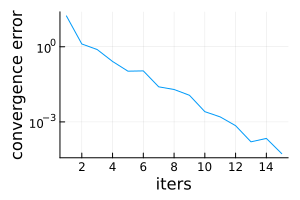

In [36]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="")

In [37]:
ns = 5*10^6
sms = sample(bp, ns)
b_mc = marginals(sms)
p_mc = [[bbb[2] for bbb in bb] for bb in b_mc];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:07:59


SIS on random regular graph N=22, k=4. P(S→I)=0.15, P(I→S)=0.12. P(zero patient)=0.136
11 random node observations at final time.
Max matrix size: 2x2


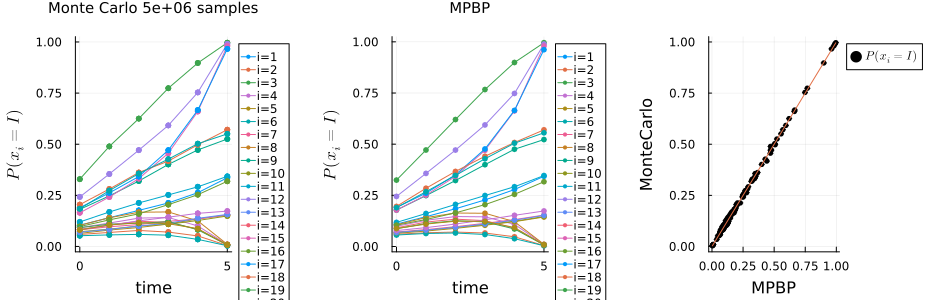

In [40]:
title = @sprintf "Monte Carlo %.0e samples" ns
pl_mc = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title=title)
for i in 1:N
    plot!(pl_mc, 0:T, p_mc[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="MPBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_sc = scatter(reduce(vcat, p_bp), reduce(vcat, p_mc), xlabel="MPBP", ylabel="MonteCarlo", 
    label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright)
plot!(identity, label="", size=(300,300))
println("SIS on random regular graph N=$N, k=$k. P(S→I)=$λ, P(I→S)=$ρ. P(zero patient)=", round(γ, digits=3))
println("$nobs random node observations at final time.")
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))